In [ ]:
# !pip install AudioSegment
# !pip install scipy
# !pip install audiomentations

In [1]:
# !rm -r 12words/
# !rm -r 12words_trimmed/

## Importing Essential Libraries

In [3]:
import os
import pathlib
import glob
import itertools
import librosa
import scipy.io.wavfile

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


from pydub import AudioSegment
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

## Retrieving and Unpacking the Dataset

In [4]:
# download dataset zip file from google drive
!gdown 1SwbFteTP21-F6T5f32zF8hvRX1cE0h8c

Downloading...
From (original): https://drive.google.com/uc?id=1SwbFteTP21-F6T5f32zF8hvRX1cE0h8c
From (redirected): https://drive.google.com/uc?id=1SwbFteTP21-F6T5f32zF8hvRX1cE0h8c&confirm=t&uuid=8205b04f-f2c5-4f31-a353-612ff3b1ce5c
To: /content/12words.zip
100% 35.1M/35.1M [00:00<00:00, 63.3MB/s]


In [5]:
# Unzip dataset
!unzip -qq -d 12words/ 12words.zip

## Detecting and Trimming Silence in Audio Data

In [6]:
DATASET_PATH = '/content/12words/'
data_dir = pathlib.Path(DATASET_PATH)

In [7]:
classes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Classes:', classes)

Classes: ['15' '1' '5' '4' '19' '7' '3' '9' '13' '8' '11' '17']


In [8]:
# https://github.com/jiaaro/pydub/tree/0c26b10619ee6e31c2b0ae26a8e99f461f694e5f

def db_to_float(db, using_amplitude=True):
    """
    Converts the input db to a float, which represents the equivalent
    ratio in power.
    """
    db = float(db)
    if using_amplitude:
        return 10 ** (db / 20)
    else:  # using power
        return 10 ** (db / 10)

def detect_silence(audio_segment, min_silence_len, silence_thresh, seek_step):
    """
    Returns a list of all silent sections [start, end] in milliseconds of audio_segment.
    Inverse of detect_nonsilent()

    audio_segment - the segment to find silence in
    min_silence_len - the minimum length for any silent section
    silence_thresh - the upper bound for how quiet is silent in dFBS
    seek_step - step size for interating over the segment in ms
    """
    seg_len = len(audio_segment)

    # you can't have a silent portion of a sound that is longer than the sound
    if seg_len < min_silence_len:
        return []

    # convert silence threshold to a float value (so we can compare it to rms)
    silence_thresh = db_to_float(silence_thresh) * audio_segment.max_possible_amplitude

    # find silence and add start and end indicies to the to_cut list
    silence_starts = []

    # check successive (1 sec by default) chunk of sound for silence
    # try a chunk at every "seek step" (or every chunk for a seek step == 1)
    last_slice_start = seg_len - min_silence_len
    slice_starts = range(0, last_slice_start + 1, seek_step)

    # guarantee last_slice_start is included in the range
    # to make sure the last portion of the audio is searched
    if last_slice_start % seek_step:
        slice_starts = itertools.chain(slice_starts, [last_slice_start])

    for i in slice_starts:
        audio_slice = audio_segment[i:i + min_silence_len]
        if audio_slice.rms <= silence_thresh:
            silence_starts.append(i)

    # short circuit when there is no silence
    if not silence_starts:
        return []

    # combine the silence we detected into ranges (start ms - end ms)
    silent_ranges = []

    prev_i = silence_starts.pop(0)
    current_range_start = prev_i

    for silence_start_i in silence_starts:
        continuous = (silence_start_i == prev_i + seek_step)

        # sometimes two small blips are enough for one particular slice to be
        # non-silent, despite the silence all running together. Just combine
        # the two overlapping silent ranges.
        silence_has_gap = silence_start_i > (prev_i + min_silence_len)

        if not continuous and silence_has_gap:
            silent_ranges.append([current_range_start,
                                  prev_i + min_silence_len])
            current_range_start = silence_start_i
        prev_i = silence_start_i

    silent_ranges.append([current_range_start,
                          prev_i + min_silence_len])

    return silent_ranges

def detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step):
    """
    Returns a list of all nonsilent sections [start, end] in milliseconds of audio_segment.
    Inverse of detect_silent()

    audio_segment - the segment to find silence in
    min_silence_len - the minimum length for any silent section
    silence_thresh - the upper bound for how quiet is silent in dFBS
    seek_step - step size for interating over the segment in ms
    """
    silent_ranges = detect_silence(audio_segment, min_silence_len, silence_thresh, seek_step)
    len_seg = len(audio_segment)

    # if there is no silence, the whole thing is nonsilent
    if not silent_ranges:
        return [[0, len_seg]]

    # short circuit when the whole audio segment is silent
    if silent_ranges[0][0] == 0 and silent_ranges[0][1] == len_seg:
        return []

    prev_end_i = 0
    nonsilent_ranges = []
    for start_i, end_i in silent_ranges:
        nonsilent_ranges.append([prev_end_i, start_i])
        prev_end_i = end_i

    if end_i != len_seg:
        nonsilent_ranges.append([prev_end_i, len_seg])

    if nonsilent_ranges[0] == [0, 0]:
        nonsilent_ranges.pop(0)

    return nonsilent_ranges

def split_on_silence(audio_segment, min_silence_len=1000, silence_thresh=-40,
                     keep_silence=250, seek_step=1):
    """
    Returns list of audio segments from splitting audio_segment on silent sections

    audio_segment - original pydub.AudioSegment() object

    min_silence_len - (in ms) minimum length of a silence to be used for
        a split. default: 1000ms

    silence_thresh - (in dBFS) anything quieter than this will be
        considered silence. default: -16dBFS

    keep_silence - (in ms or True/False) leave some silence at the beginning
        and end of the chunks. Keeps the sound from sounding like it
        is abruptly cut off.
        When the length of the silence is less than the keep_silence duration
        it is split evenly between the preceding and following non-silent
        segments.
        If True is specified, all the silence is kept, if False none is kept.
        default: 100ms

    seek_step - step size for interating over the segment in ms
    """

    # from the itertools documentation
    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    if isinstance(keep_silence, bool):
        keep_silence = len(audio_segment) if keep_silence else 0

    output_ranges = [
        [ start - keep_silence, end + keep_silence ]
        for (start,end)
            in detect_nonsilent(audio_segment, min_silence_len, silence_thresh, seek_step)
    ]

    for range_i, range_ii in pairwise(output_ranges):
        last_end = range_i[1]
        next_start = range_ii[0]
        if next_start < last_end:
            range_i[1] = (last_end+next_start)//2
            range_ii[0] = range_i[1]

    return [
        audio_segment[ max(start,0) : min(end,len(audio_segment)) ]
        for start,end in output_ranges
    ]


In [9]:
def trim_mp3(mp3_file, output_folder):
    audio_segment = AudioSegment.from_mp3(mp3_file)
    os.makedirs(output_folder, exist_ok=True)
    audio_segment_list = split_on_silence(audio_segment)
    for idx, extracted_audio_segment in enumerate(audio_segment_list):
        if extracted_audio_segment.duration_seconds > 0.75:
            out_fn = os.path.join(output_folder,
                                  os.path.splitext(os.path.basename(mp3_file))[0] + "_" + str(idx) + "_extracted.mp3")
            extracted_audio_segment.export(out_fn, format="mp3")

In [10]:
# ~ 4 min
for f in glob.glob(os.path.join(DATASET_PATH, '*/*.mp3')):
    trim_mp3(f, os.path.dirname(f))

## Converting MP3 Audio Files to WAV Format

In [11]:
# function for converting mp3 file into wav file
def convert_mp3_to_wav(mp3_file, output_folder):
    sound = AudioSegment.from_mp3(mp3_file)
    os.makedirs(output_folder, exist_ok=True)
    wav_fn = os.path.join(output_folder, os.path.splitext(os.path.basename(mp3_file))[0] + ".wav")
    duration = sound.duration_seconds
    sound.set_frame_rate(16000).export(wav_fn, format="wav")
    return duration

In [12]:
durations = []

for f in glob.glob(os.path.join(DATASET_PATH, '*/*_extracted.mp3')):
  d = convert_mp3_to_wav(f, os.path.dirname(f))
  durations.append(d)

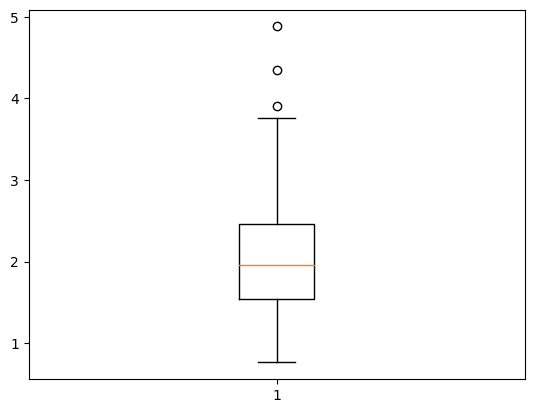

In [13]:
durations_np = np.array(durations)

plt.boxplot(durations_np)

plt.show()

In [14]:
SAMPLE_RATE = 16000
DURATION = 4

## Data Augmentation Pipeline for Audio Files

In [15]:
augment_vo = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(p=0.5),
])

In [16]:
augment_vt = Compose([
    AddGaussianNoise(min_amplitude=0.005, max_amplitude=0.02, p=0.5),
    TimeStretch(min_rate=0.75, max_rate=1.5, p=0.5),
    PitchShift(min_semitones=-3, max_semitones=3, p=0.5),
    Shift(p=0.7),
])

In [17]:
def augment_audio(samples, sample_rate, augment_func):
    augmented_samples = augment_func(samples=samples, sample_rate=sample_rate)
    if augmented_samples.dtype != 'int16':
        augmented_samples = (augmented_samples * 32767).astype('int16')  # Convert to 16-bit PCM
    return augmented_samples

In [18]:
augment_functions = [augment_vt, augment_vo]
for index, augment_function in enumerate(augment_functions):
  for f in glob.glob(os.path.join(DATASET_PATH, '*/*_extracted.wav')):
      data = librosa.core.load(f)[0]
      sound_aug = augment_audio(data, SAMPLE_RATE, augment_function)
      wav_aug = os.path.join(os.path.dirname(f), os.path.splitext(os.path.basename(f))[0] +'_'+str(index)+ '_aug' + ".wav")
      scipy.io.wavfile.write(wav_aug, SAMPLE_RATE, sound_aug)

## Clean Data

In [19]:
!cp -r 12words/ 12words_trimmed/

In [20]:
!rm 12words/*/*.mp3

In [21]:
!rm 12words_trimmed/*/*\).wav

rm: cannot remove '12words_trimmed/*/*).wav': No such file or directory


In [22]:
!rm 12words_trimmed/*/*.mp3

## Audio Dataset Splitting for Training and Testing

In [23]:
DATASET_PATH = '/content/12words_trimmed/'
data_dir = pathlib.Path(DATASET_PATH)

In [24]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=DURATION*SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 1404 files belonging to 12 classes.
Using 1124 files for training.
Using 280 files for validation.

label names: ['1' '11' '13' '15' '17' '19' '3' '4' '5' '7' '8' '9']


In [25]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [26]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [27]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 64000)
(64,)


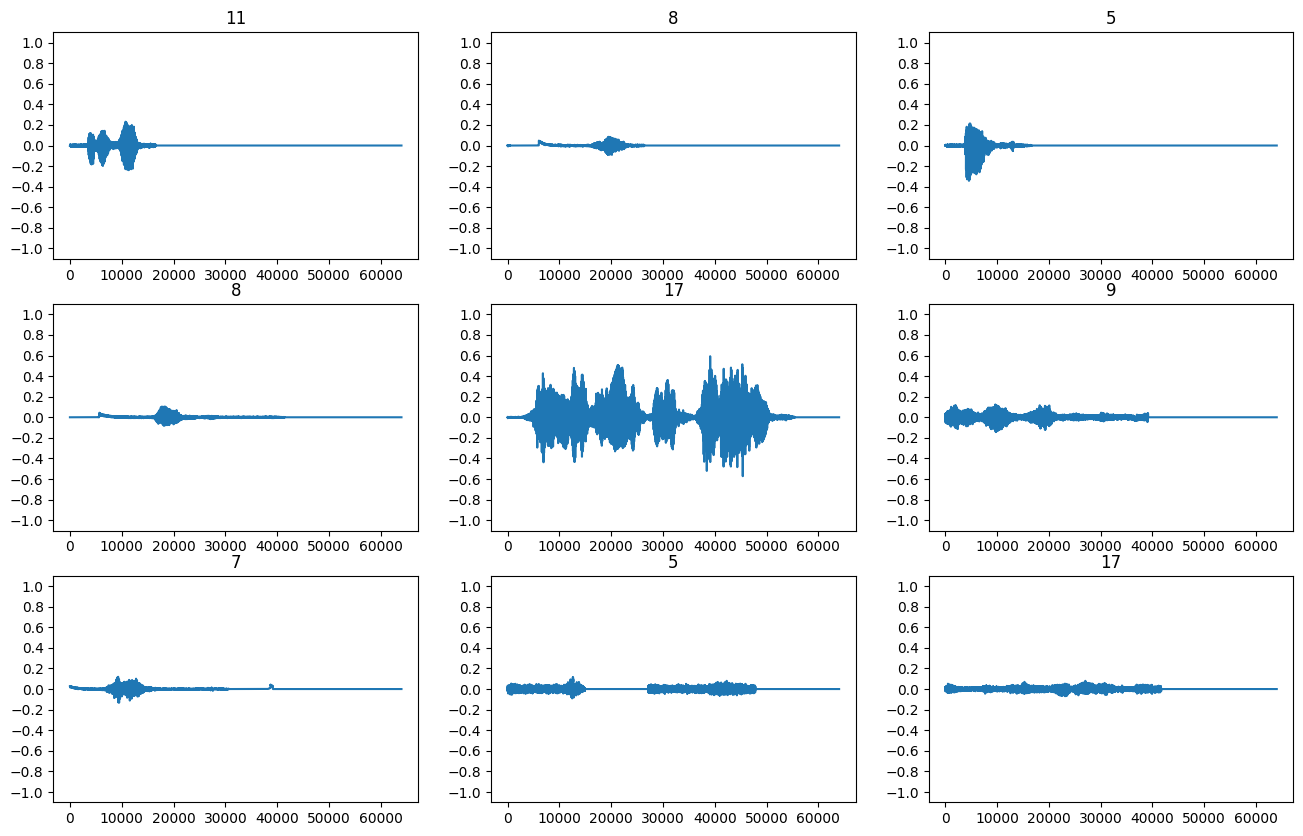

In [28]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## Spectrogram Generation from Audio Data

In [29]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [30]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=SAMPLE_RATE))

Label: 11
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 8
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 5
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


In [31]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

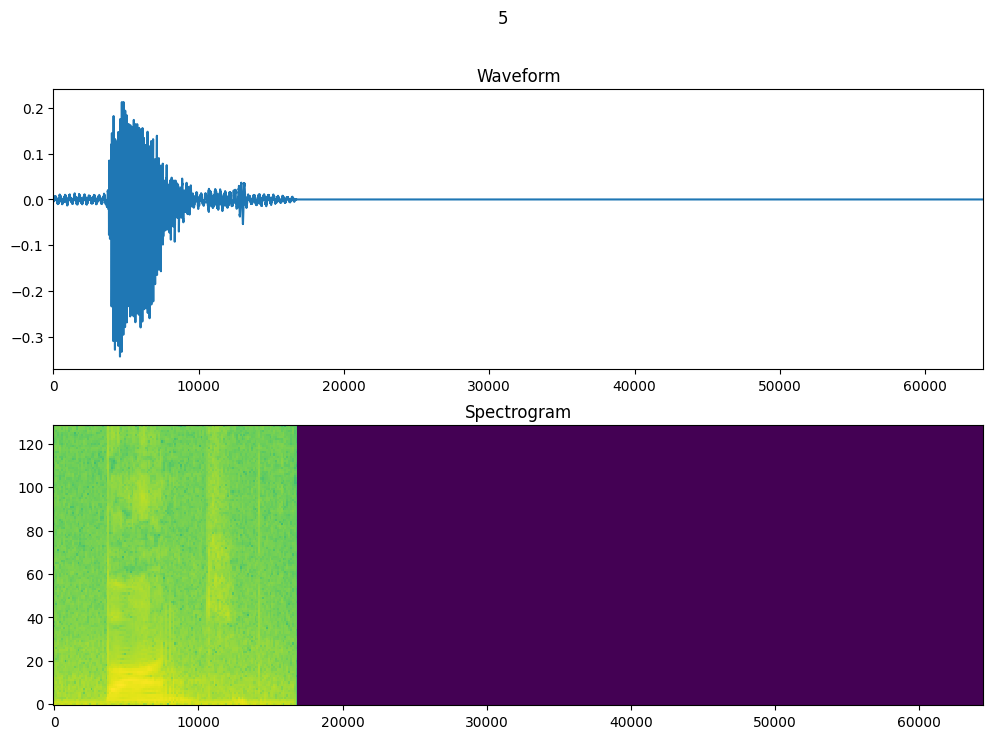

In [32]:

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, DURATION*SAMPLE_RATE])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [33]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [35]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

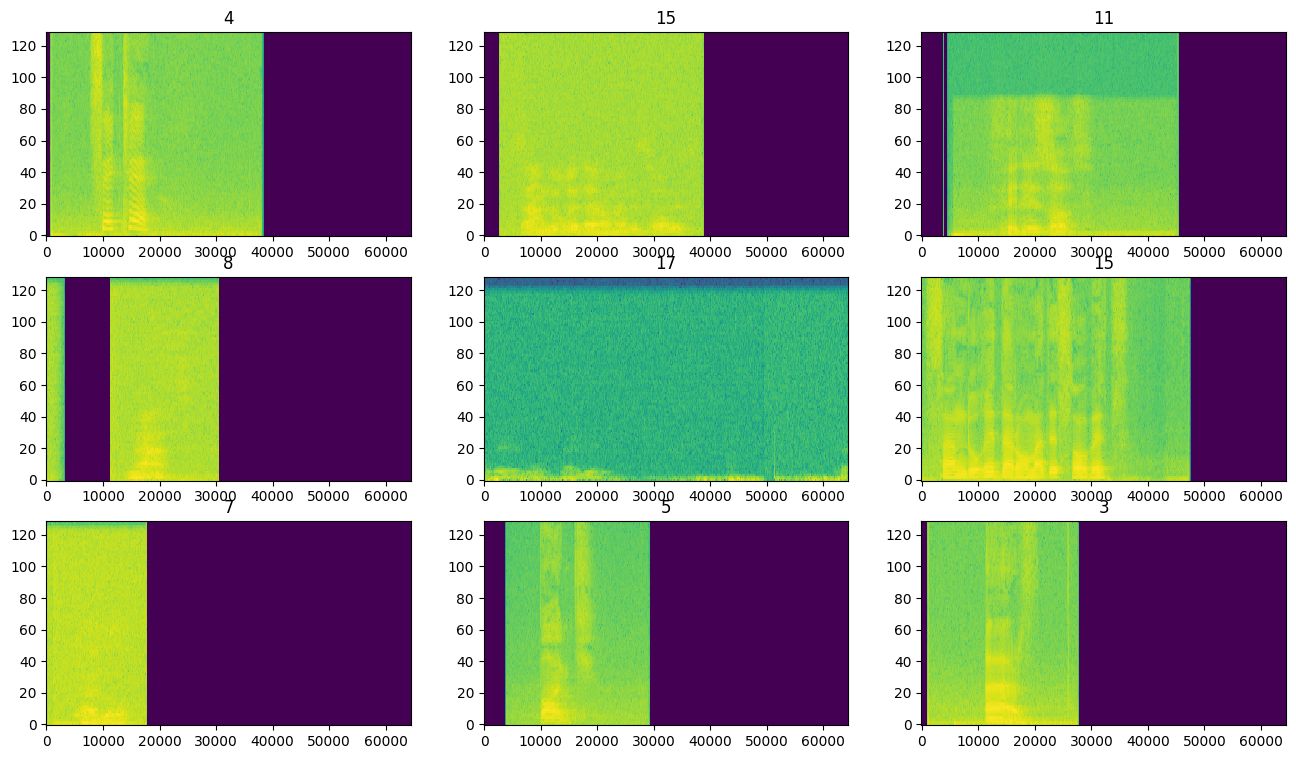

In [36]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [37]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model Training Pipeline for Audio Classification

In [38]:
# Define the checkpoint file path
MODEL_PATH = '/content/'
checkpoint_path = os.path.join(MODEL_PATH, 'model_checkpoint.h5')

In [39]:
from keras.regularizers import l2

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print(num_labels)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer,
    layers.Conv2D(16, 3, strides=2, activation=None, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(16, 3, strides=1, activation=None, padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(16, 3, strides=1, activation=None, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(16, 3, strides=1, activation=None, padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(32, 3, strides=2, activation=None, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(32, 3, strides=1, activation=None, padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, strides=1, activation=None, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(32, 3, strides=1, activation=None, padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_labels, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
])

model.summary()

Input shape: (499, 129, 1)
12
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 16)        64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)        

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [41]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=15),
               tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)]
)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 4.1898 - accuracy: 0.0952
Epoch 1: val_accuracy improved from -inf to 0.10156, saving model to /content/model_checkpoint.h5
18/18 [==============================] - 13s 473ms/step - loss: 4.1898 - accuracy: 0.0952 - val_loss: 3.8124 - val_accuracy: 0.1016


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 3.6886 - accuracy: 0.0943
Epoch 2: val_accuracy improved from 0.10156 to 0.11719, saving model to /content/model_checkpoint.h5
18/18 [==============================] - 7s 402ms/step - loss: 3.6886 - accuracy: 0.0943 - val_loss: 3.5601 - val_accuracy: 0.1172
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 3.4387 - accuracy: 0.0907
Epoch 3: val_accuracy did not improve from 0.11719
18/18 [==============================] - 6s 326ms/step - loss: 3.4387 - accuracy: 0.0907 - val_loss: 3.3329 - val_accuracy: 0.1094
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 3.2291 - accuracy: 0.0934
Epoch 4: val_accuracy did not improve from 0.11719
18/18 [==============================] - 7s 403ms/step - loss: 3.2291 - accuracy: 0.0934 - val_loss: 3.1677 - val_accuracy: 0.0781
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 3.0848 - accuracy: 0.0854
Epoch 5: val_accuracy di

Text(0, 0.5, 'Accuracy [%]')

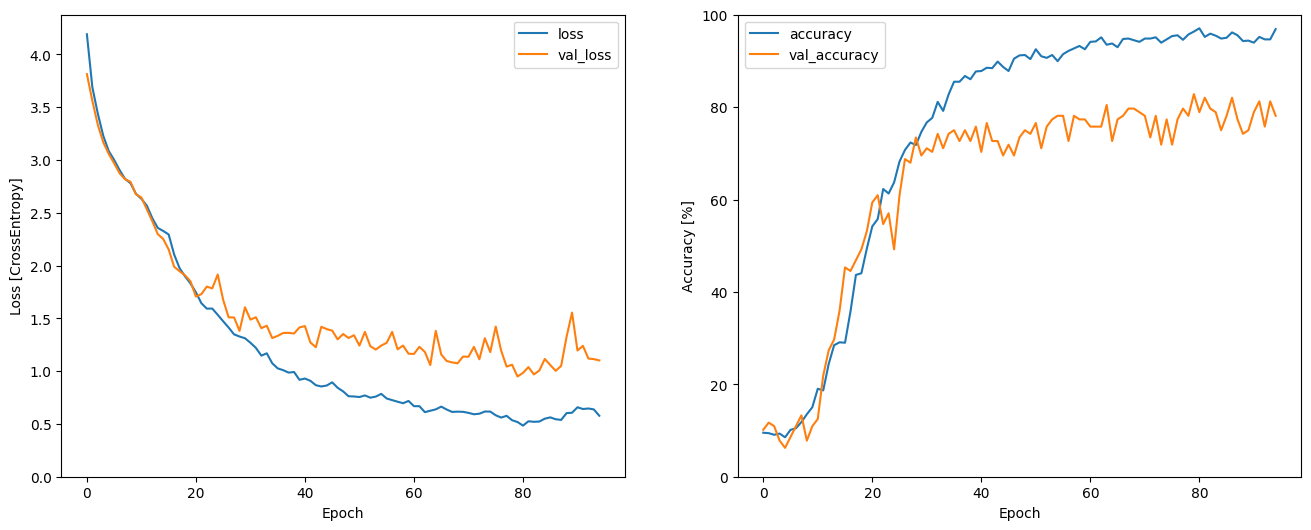

In [43]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Model Evaluation

In [44]:
model.evaluate(test_spectrogram_ds, return_dict=True)

3/3 [==============================] - 1s 184ms/step - loss: 1.0707 - accuracy: 0.8092


{'loss': 1.070662021636963, 'accuracy': 0.8092105388641357}

In [45]:
y_pred = model.predict(test_spectrogram_ds)

3/3 [==============================] - 0s 58ms/step


In [46]:
y_pred = tf.argmax(y_pred, axis=1)

In [47]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

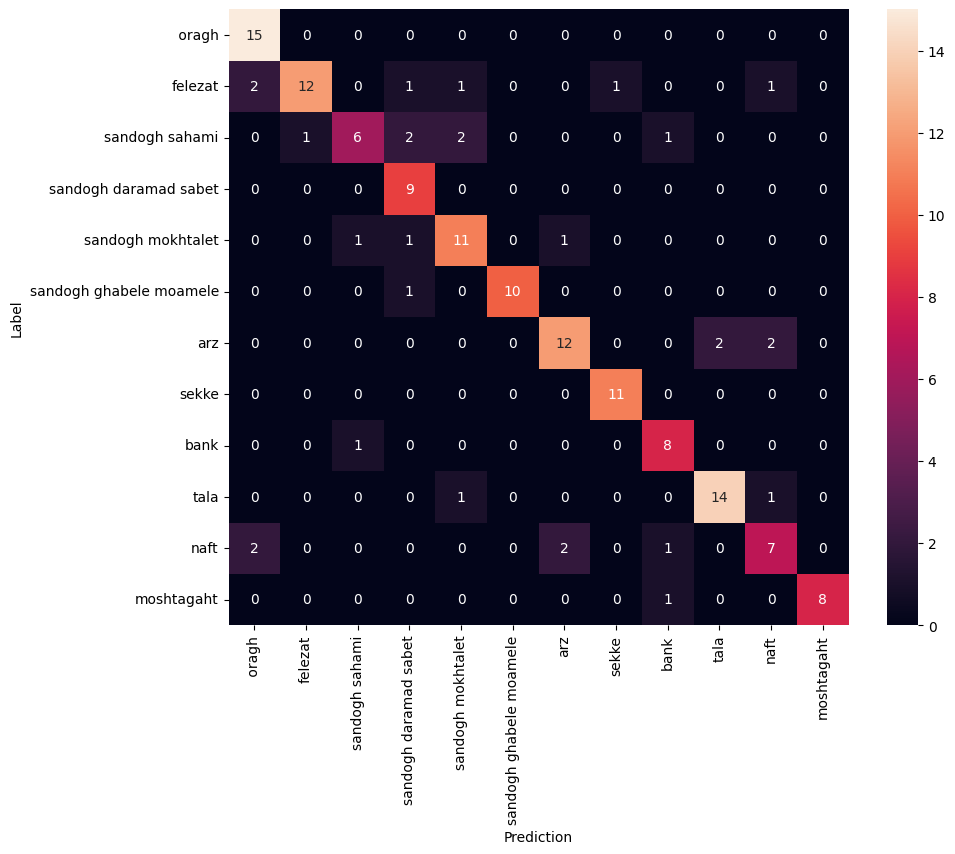

In [51]:
class_mapping = {
    '1': ' oragh',
    '13': 'sandogh sahami',
    '19': 'sandogh ghabele moamele',
    '17': 'sandogh mokhtalet',
    '15': 'sandogh daramad sabet',
    '11': 'felezat',
    '9': 'moshtagaht',
    '8': 'naft',
    '7': 'tala',
    '5': 'bank',
    '4': 'sekke',
    '3': 'arz',
}

class_names = [class_mapping[label] for label in label_names]

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()